In [1]:
from stdb import load_db 
import obspy 
import pickle
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import glob

from sklearn.decomposition import PCA

In [2]:
def calc_CpH(trE,trN):
    X = np.array([trE.data,trN.data])
    X = X.T
    pca = PCA(n_components=2)
    pca = pca.fit(X)
    eigval = pca.singular_values_
    values = 1-eigval[1]/eigval[0]
    return round(values,2)

def deltaphi(RCphi,SCphi):
    phi = max(abs(RCphi-SCphi),abs(SCphi-RCphi) )
    if phi >90:
        phi = 180-phi
    return phi

def init_pmotion(ax,title):
    ax.clear()
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlim((-1.2, 1.2))
    ax.set_yticks(())
    ax.set_xticks(())
    ax.set_xlabel(r'W $\longleftrightarrow$ E')
    ax.set_ylabel(r'S $\longleftrightarrow$ N')
    ax.set_title(title, fontsize=16,fontweight='bold')
    return ax

def searchfile(path):
    calc_type = 'manual'
    Meta_pkl = path + '/Meta_manual.pkl'
    Station_data_pkl = path + '/Station_data.pkl'
    ZNE_pkl = path + '/ZNE_data.pkl'
    LQT_pkl = path + '/LQT_data.pkl'
    Split_result_pkl = path + '/Split_results_manual.pkl'
    SC_result_pkl = path + '/SC_res_manual.pkl'
    RC_result_pkl = path + '/RC_res_manual.pkl'

    Meta = pickle.load(open(Meta_pkl, "rb"))
    Station_data = pickle.load(open(Station_data_pkl, "rb"))
    ZNE = pickle.load(open(ZNE_pkl, "rb"))
    LQT = pickle.load(open(LQT_pkl, "rb"))
    Split_result = pickle.load(open(Split_result_pkl, "rb"))
    SC_res = pickle.load(open(SC_result_pkl, "rb"))
    RC_res = pickle.load(open(RC_result_pkl, "rb"))
    
    return calc_type,Meta,Station_data,ZNE,LQT,Split_result,SC_res,RC_res

/Volumes/home/Research/STEP/01_Split/DATA_SKS_Mw7/GO.AKH/20161124_184348/
manual
2 pick


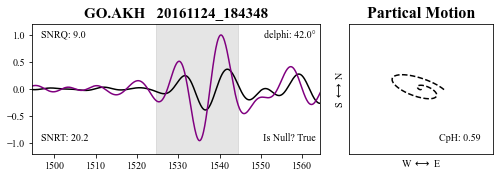

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
path='/Volumes/home/Research/STEP/01_Split'
stapath = 'DATA_SKS_Mw7/GO.AKH/20161124_184348/'
for datapath in glob.glob(f'{path}/{stapath}'):
    fig = plt.figure(figsize=(8, 3), facecolor='w')
    print(datapath)
    calc_type,Meta,Station_data,ZNE,LQT,Split_result,SC_res,RC_res = searchfile(datapath)
    print(calc_type)
    try:
        print('2 pick')
        win_begin = Meta.tpicked1
        win_end   = Meta.tpicked2
    except:
        print('1 pick')
        win_begin = Meta.tpicked-5
        win_end   = Meta.tpicked+25
    t1 = Meta.time + win_begin #+ Meta.ttime 
    t2 = Meta.time + win_end   #+ Meta.ttime
    
    ZNE_use = ZNE.slice(t1,t2)
    ZNE_use = ZNE_use.filter('bandpass',freqmin=0.05,freqmax=0.125,corners=4,zerophase=True)
    CpH = Meta.CpH
    dp = deltaphi(RC_res.phi,SC_res.phi)
    
    ax0 = fig.add_axes([0.05, 0.0, 0.5, 0.6])
    time = LQT[0].times(reftime=Meta.time)
    LQT_use = LQT.slice(t1,t2)
    trQ  = LQT.select(component='Q')[0]
    trT  = LQT.select(component='T')[0]
    ax0.fill_between([win_begin,win_end],y1=-1.3,y2=1.3,color = 'grey',alpha = 0.2)
    pmax = max(max(abs(LQT_use[1].data)),max(abs(LQT_use[2].data)))
    plt.plot(time, trT.data/pmax, 'black')
    plt.plot(time, trQ.data/pmax, 'purple')
    plt.ylim(-1.2,1.2)
    plt.xlim(win_begin-30, win_end+20)
    plt.text(win_begin-28,-1,f'SNRT: {round(Meta.snrt,1)}', ha='left',va='bottom', fontsize=10)
    plt.text(win_begin-28,0.9,f'SNRQ: {round(Meta.snrq,1)}', ha='left',va='bottom', fontsize=10)
    plt.text(win_end+20,-1,f'{Split_result.rsplit("/")[0]}  ', ha='right',va='bottom', fontsize=10)
    plt.text(win_end+20,0.9,f'delphi: {round(dp,0)}°  ',ha='right',va='bottom', fontsize=10)
    plt.title(f'{datapath.rsplit("/")[-3]}   {datapath.rsplit("/")[-2]}', fontsize=15, fontweight='bold')
    
    
    axp = fig.add_axes([0.6, 0.0,  0.25, 0.6])
    axp = init_pmotion(ax=axp,title = 'Partical Motion')
    axp.plot(ZNE_use.select(component='E')[0].data/pmax, ZNE_use.select(component='N')[0].data/pmax, 'k--') 
    axp.text(1,-1,f'CpH: {CpH}',ha='right',va='bottom')
    
    fig.savefig(f'{datapath.rsplit("/")[-3]}_{datapath.rsplit("/")[-2]}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'{datapath.rsplit("/")[-3]}_{datapath.rsplit("/")[-2]}.pdf', bbox_inches='tight')
    

In [4]:
file = '/Volumes/home/06_NTU_thesis/Thesis_figure/Sup/catalog/catalog.csv'

In [5]:
df = pd.read_csv(file)

In [6]:
qqq =df[df['Null']==True][df['CpH']==0.77]

/var/folders/sp/pnngww1n0q31w2plgbk53rc00000gn/T/ipykernel_67879/3664361921.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qqq =df[df['Null']==True][df['CpH']==0.77]


In [8]:
for ii in range(len(qqq)):
    SCphi = qqq['SCPhi'].values[ii]
    RCphi = qqq['RCPhi'].values[ii]
    delphi = deltaphi(RCphi,SCphi)
    if  not 25<delphi<68:
        print(qqq['Station'].values[ii], qqq['Event'].values[ii], qqq['CpH'].values[ii])

AM.ZARN 20171127_071111 0.77


In [21]:
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000


In [37]:
!open .